---
## Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 1. Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(y_train)

# Number of testing examples.
n_test = len(y_test)

# Shape of an traffic sign image.
image_shape = X_train.shape[1:4]

# Number of classes.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the images

8


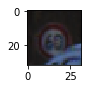

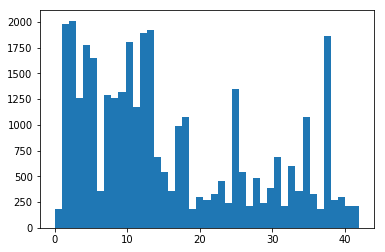

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline

# Shows random image from the training set
plt.figure(figsize=(1,1))
index = randint(0, len(X_train))
plt.imshow(X_train[randint(0, index)])
print(y_train[index])

# Plot training data counts for each class
plt.figure()
hist_plot = plt.hist(y_train, n_classes)

----

## 2. Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test model on the [German Traffic Sign Dataset]

### Pre-process the Data Set

In [5]:
# Normalization
X_train = (X_train - 177.5) / 255
X_valid = (X_valid - 177.5) / 255

# Shuffle Data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture (based on LeNet)

In [6]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x128
    conv1_W = tf.Variable(tf.truncated_normal(shape = (3, 3, 3, 128), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(128))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding = 'VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 30x30x128. Output = 15x15x128.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 12x12x64
    conv2_W = tf.Variable(tf.truncated_normal(shape = (4, 4, 128, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding = 'VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 12x12x64. Output = 6x6x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
     # Layer 3: Convolutional. Output = 5x5x32
    conv3_W = tf.Variable(tf.truncated_normal(shape = (2, 2, 64, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding = 'VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Flatten. Input = 5x5x32. Output = 800.
    fc0 = flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 800. Output = 200.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_w) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 200. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_w) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
# Creat Placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [8]:
# Training Pipeline
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [9]:
# Train the Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.814

EPOCH 2 ...
Validation Accuracy = 0.906

EPOCH 3 ...
Validation Accuracy = 0.946

EPOCH 4 ...
Validation Accuracy = 0.939

EPOCH 5 ...
Validation Accuracy = 0.962

EPOCH 6 ...
Validation Accuracy = 0.959

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.959

EPOCH 9 ...
Validation Accuracy = 0.962

EPOCH 10 ...
Validation Accuracy = 0.960

Model saved


---

## Step 3: Test a Model on New Images

### Load and Output the Images

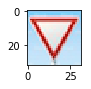

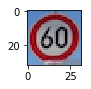

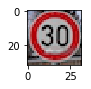

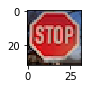

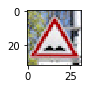

In [68]:
# Pardon the concatenation here, I was in a hurry to get things running.
import cv2
sign_1 = cv2.imread('test_image/1.jpg')
sign_1 = cv2.cvtColor(sign_1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(sign_1)
sign_2 = cv2.imread('test_image/2.jpg')
sign_2 = cv2.cvtColor(sign_2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(sign_2)
sign_3 = cv2.imread('test_image/3.jpg')
sign_3 = cv2.cvtColor(sign_3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(sign_3)
sign_4 = cv2.imread('test_image/4.jpg')
sign_4 = cv2.cvtColor(sign_4, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(sign_4)
sign_5 = cv2.imread('test_image/5.jpg')
sign_5 = cv2.cvtColor(sign_5, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(sign_5)

### Predict the Sign Type for Each Image

In [69]:
# Run the predictions and use the model to output the prediction for each image.
import numpy as np
X_test = np.stack((sign_1, sign_2, sign_3, sign_4, sign_5), axis=0)

# Normalization
X_test = (X_test - 177.5) / 255

softmax_operation = tf.nn.softmax(logits)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    output = sess.run(softmax_operation, feed_dict={x: X_test[0:5], keep_prob: 1})
    print('The corresponding results for signs 1 to 5 are:', np.argmax(output, axis=1))

The corresponding results for signs 1 to 5 are: [13  3  1 14 22]


In [71]:
print('13: Yield \n3 : Speed Limit (60) \n1 : Speed Limit (30) \n14: Stop \n22: Bumpy Road')

13: Yield 
3 : Speed Limit (60) 
1 : Speed Limit (30) 
14: Stop 
22: Bumpy Road


### Analyze Performance

In [72]:
### Calculate the accuracy for these 5 new images. 
print('The ConvNet I trained has 100% accuracy based on the results of the output from the images found online')

The ConvNet I trained has 100% accuracy based on the results of the output from the images found online


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [73]:
# Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
softmax_operation = tf.nn.softmax(logits)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    output = sess.run(softmax_operation, feed_dict={x: X_test[0:5], keep_prob: 1})
    print(sess.run(tf.nn.top_k(output, k=5)))
    print('We can see from the Softmax output that the network is very deterministic about the outputs since the top\
 probabilities in all cases are almost 1.')

TopKV2(values=array([[  1.00000000e+00,   6.67528258e-36,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.98090088e-01,   1.90376397e-03,   6.22804009e-06,
          1.56077859e-10,   7.85157564e-11],
       [  1.00000000e+00,   1.43336198e-09,   3.61532787e-12,
          2.18490726e-13,   1.87354768e-16],
       [  9.98993695e-01,   1.00622070e-03,   2.25351329e-08,
          8.47538839e-09,   1.75282910e-09],
       [  1.00000000e+00,   4.13619134e-18,   5.45417757e-20,
          9.26348711e-25,   1.24136545e-25]], dtype=float32), indices=array([[13,  3,  0,  1,  2],
       [ 3,  2,  5,  1, 34],
       [ 1,  2,  0,  4,  3],
       [14,  1,  2,  3, 29],
       [22, 29, 25, 26, 23]], dtype=int32))
We can see from the Softmax output that the network is very deterministic about the outputs since the top probabilities in all cases are almost 1.
